In [2]:
# !pip install keras-core

In [90]:
import os

os.environ['KERAS-BACKEND'] = 'tensorflow'
import keras_core as keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')

In [91]:
print(f"current working directory {os.getcwd()}")

current working directory /kaggle


In [92]:
os.chdir('/kaggle')

In [93]:
train_and_val_path = '/kaggle/input/multiclassimagedatasetairplanecar/Dataset/train'
test_path = '/kaggle/input/multiclassimagedatasetairplanecar/Dataset/test'

batch_size = 16
color_mode = 'rgb'
image_size = (224,224)
test_class_names = ['airplanes', 'cars', 'ships']
class_names = ['airplanes', 'cars', 'ship']

In [94]:
train_batch, valid_batch = image_dataset_from_directory(
    directory = train_and_val_path,
    batch_size = batch_size,
    color_mode = color_mode,
    image_size = image_size,
    shuffle = True,
    seed = 0,
    class_names = class_names,
    validation_split = .2,
    subset = 'both'
)

test_batch = image_dataset_from_directory(
    directory = test_path,
    batch_size = batch_size,
    color_mode = color_mode,
    image_size = image_size,
    shuffle = False,
#     seed = 42,
    class_names = test_class_names
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Using 600 files for validation.
Found 582 files belonging to 3 classes.


In [95]:
def rescale(img, lbl):
    img_ = img / 255.0
    return img_, lbl

train_batch = train_batch.map(rescale)
valid_batch = valid_batch.map(rescale)
test_batch = test_batch.map(rescale)

In [96]:
# save images and labels for plotting
train_images = []
train_labels = []

for image, label in train_batch.unbatch():
    train_images.append(image)
    if label == 0:
        train_labels.append('Airplane')
    elif label == 1:
        train_labels.append('Car')
    elif label == 2:
        train_labels.append('Ship')
        
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

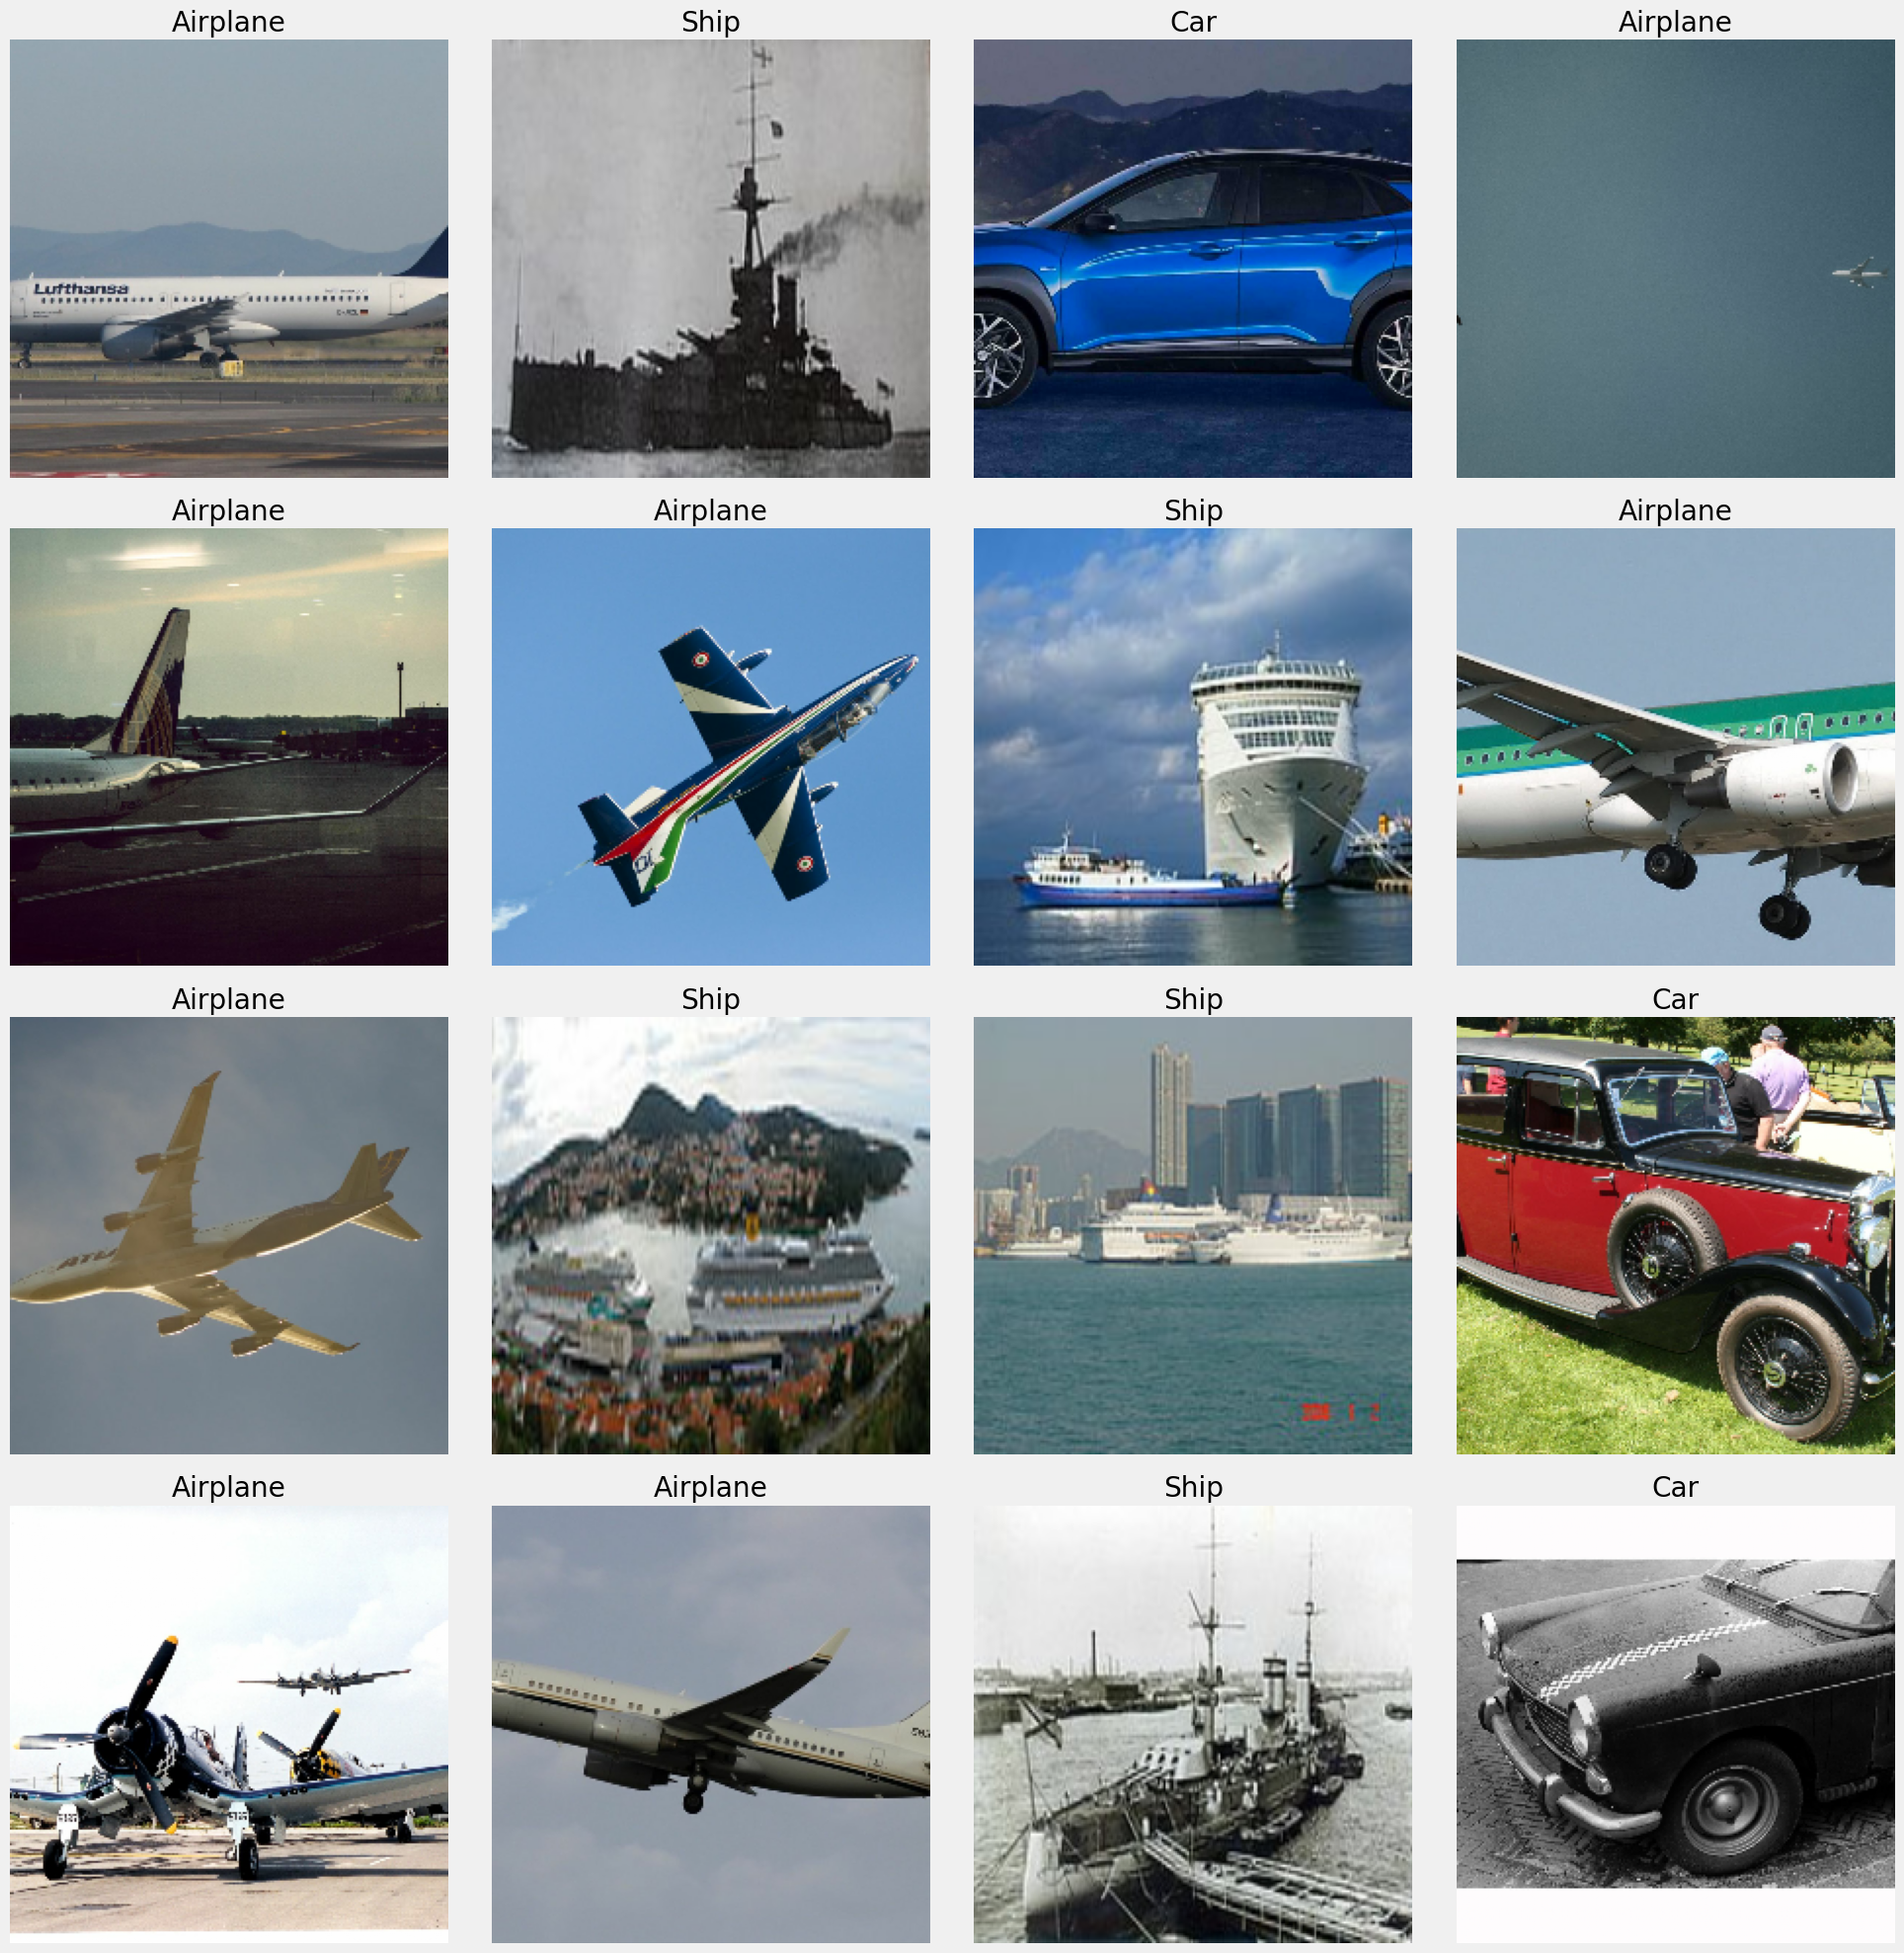

In [97]:
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (20,20))
ax = ax.flatten()

for img, lbl, axi in zip(train_images[:16], train_labels[:16], ax):
    axi.imshow(img)
    axi.set_title(lbl)
    axi.axis('off')
    
plt.tight_layout()

In [98]:
import tensorflow as tf
import tensorflow.image

In [99]:
# help(tf.image.resize)

In [100]:
# augment train images using tensorflow.image
def augment(img, lbl):
    img_ = tf.image.random_flip_left_right(img, seed = 42)
    img_ = tf.image.central_crop(img_, central_fraction = .9)
    img_ = tf.image.resize(img_, size = image_size)
    
    return img_, lbl
    
train_batch = train_batch.map(augment)

In [101]:
# save images and labels for plotting
train_images = []
train_labels = []

for image, label in train_batch.unbatch():
    train_images.append(image)
    if label == 0:
        train_labels.append('Airplane')
    elif label == 1:
        train_labels.append('Car')
    elif label == 2:
        train_labels.append('Ship')
        
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

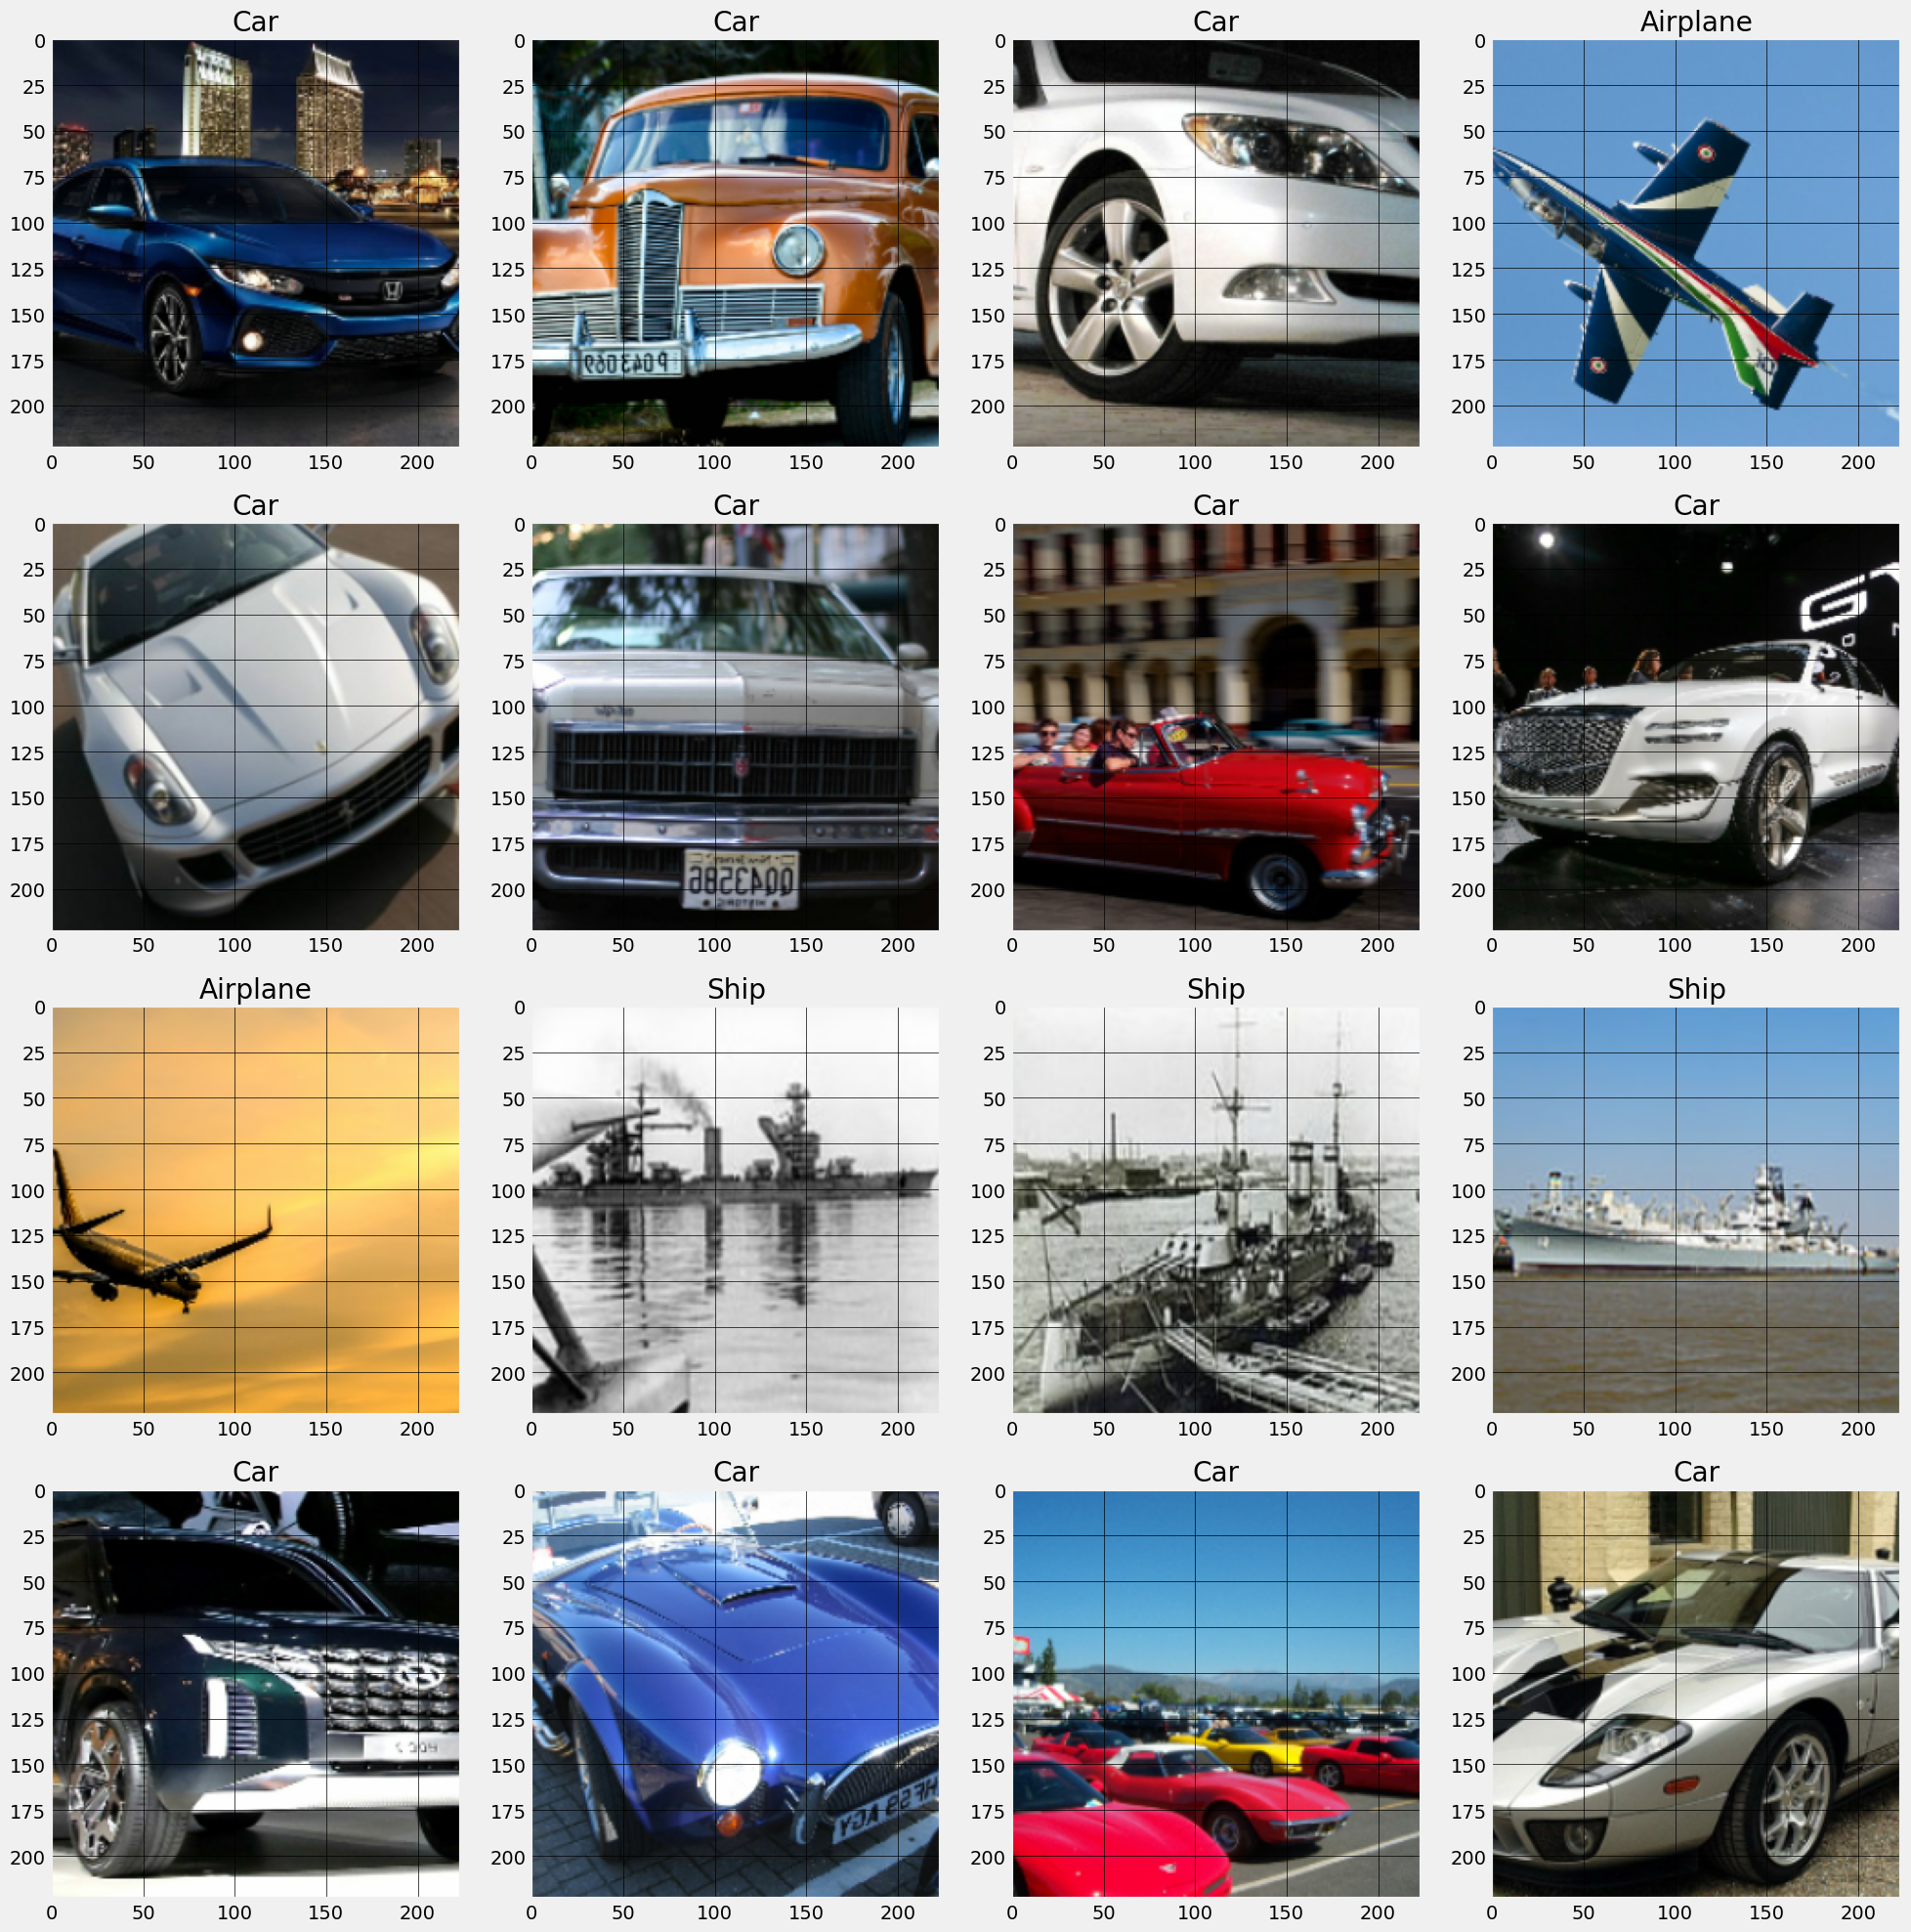

In [102]:
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (20,20))
ax = ax.flatten()

for img, lbl, axi in zip(train_images[:16], train_labels[:16], ax):
    axi.imshow(img)
    axi.set_title(lbl)
    axi.axis('on')
    axi.grid(axis = 'both', color = 'black', lw = .5)
    
plt.tight_layout()

In [103]:
# Create model

def create_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', input_shape = (224, 224, 3), kernel_initializer = 'he_uniform', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(rate = .25))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = 'he_uniform', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(rate = .25))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = 'he_uniform', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(rate = .25))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = 'he_uniform', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(rate = .25))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = 'he_uniform', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Flatten())
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'softmax'))
    
    model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = SparseCategoricalCrossentropy(),
        metrics = [
            SparseCategoricalAccuracy(name = 'acc')
        ]
    )
    
    return model

In [104]:
logs = '/kaggle/working/logs/logs'

board_ = TensorBoard(
    log_dir = logs,
    histogram_freq=1,
    profile_batch = 2
)

stops_ = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    patience = 15,
    mode = 'min'
)

In [105]:
model = create_model()

In [106]:
epochs = 100

callbacks = [
    board_,
    stops_
]

model.fit(
    train_batch,
    epochs = epochs,
    validation_data = valid_batch,
    callbacks = callbacks,
    verbose = 1
)
# score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/100


2023-07-14 00:07:20.860937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 [==============================] - 23s 100ms/step - loss: 0.7245 - sparse_categorical_accuracy: 0.6979 - val_loss: 2.2576 - val_sparse_categorical_accuracy: 0.4450
Epoch 2/100
150/150 [==============================] - 15s 98ms/step - loss: 0.4770 - sparse_categorical_accuracy: 0.8150 - val_loss: 2.4234 - val_sparse_categorical_accuracy: 0.4683
Epoch 3/100
150/150 [==============================] - 15s 94ms/step - loss: 0.3221 - sparse_categorical_accuracy: 0.8750 - val_loss: 0.9211 - val_sparse_categorical_accuracy: 0.6867
Epoch 4/100
150/150 [==============================] - 16s 100ms/step - loss: 0.2479 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.3367 - val_sparse_categorical_accuracy: 0.8800
Epoch 5/100
150/150 [==============================] - 15s 94ms/step - loss: 0.2189 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9167
Epoch 6/100
150/150 [==============================] - 15s 98ms/step - loss: 0.2022 - sparse_ca

In [107]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_10 (Bat  (None, 112, 112, 32)   

In [108]:
df = pd.DataFrame(data = model.history.history)
df.head(10)

loss  sparse_categorical_accuracy  val_loss  \
0  0.724545                     0.697917  2.257645   
1  0.476988                     0.815000  2.423387   
2  0.322063                     0.875000  0.921108   
3  0.247909                     0.912500  0.336694   
4  0.218915                     0.912917  0.254734   
5  0.202238                     0.923750  0.444743   
6  0.195583                     0.934167  0.331876   
7  0.178816                     0.931667  0.582698   
8  0.158559                     0.938333  0.295254   
9  0.157265                     0.942500  0.244330   

   val_sparse_categorical_accuracy  
0                         0.445000  
1                         0.468333  
2                         0.686667  
3                         0.880000  
4                         0.916667  
5                         0.865000  
6                         0.913333  
7                         0.796667  
8                         0.910000  
9                         0.935000

<Axes: >

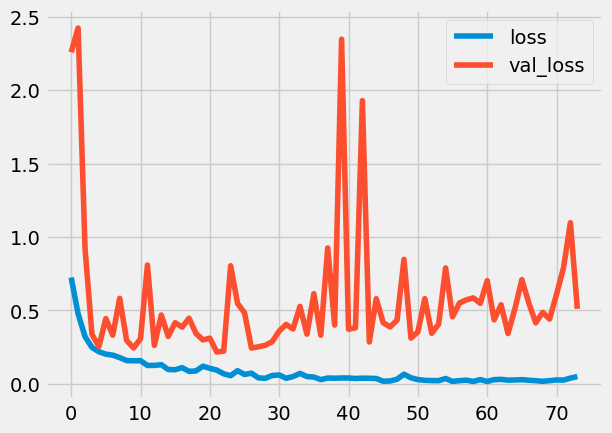

In [109]:
df[['loss', 'val_loss']].plot.line()

In [112]:
# %reload_ext tensorboard
# %tensorboard --logdir /kaggle/working/logs/logs --port 6536 

In [113]:
# save images and labels for plotting
test_images = []
test_labels = []

for image, label in test_batch.unbatch():
    test_images.append(image)
    if label == 0:
        test_labels.append(0)
    elif label == 1:
        test_labels.append(1)
    elif label == 2:
        test_labels.append(2)
        
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [114]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [128]:
preds = model.predict(test_batch, verbose = 1)
preds = np.argmax(preds, axis = 1)
preds

37/37 [==============================] - 2s 61ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [129]:
test_labels.dtype

dtype('int64')

In [130]:
import sklearn
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [131]:
# Evaluate
acc_score = accuracy_score(test_labels,preds)
print("Accuracy score:", acc_score)

Accuracy score: 0.9106529209621993


In [132]:
model.save('/kaggle/working/final_model.h5')